In [1]:
from GA_keras import GA, ga_main
import tensorflow as tf
import keras
import numpy as np
import cv2
import redis
import pickle
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
from tqdm import tqdm
import os


Using TensorFlow backend.


In [270]:
'''
Helper functions
'''

# save mutated inputs
def save_ckpt(mutated_inputs, fitness_func, model_name, dl_framework, db_flag=5):
    r = redis.Redis(db=db_flag)
    r.hset(f"{fitness_func}_{model_name}_ckpt",  dl_framework, pickle.dumps(mutated_inputs))
    
'''
example of usage:
save_ckpt(ga.selected_x, 'inc', 'vgg16', 'tf_th', db_flag=5)
'''

# load muated inputs
def load_ckpt(fitness_func, model_name, dl_framework, db_flag=5):
    r = redis.Redis(db=db_flag)
    return pickle.loads(r.hget(f"{fitness_func}_{model_name}_ckpt", dl_framework))

'''
example of usage:
inc_ckpt = load_ckpt('inc', 'vgg16', 'tf_th', db_flag=5)
'''

# plot fitness values over iterations
def plot_fits(fits):
    fit_grad = lambda L: [np.mean(i[1]) for i in L]
    plt.plot(fit_grad(fits))
    
'''
example of usage:
plot_fits(fits)
'''

# From existing dataset, find the k inputs with the highest fitness values
def get_highest_fits(fit, model, X, layer_idx, db_flag, k, num_batch):
    '''
    X: shape of 4 dim
    '''
    def get_fits(fit, model, x, layer_idx, db_flag, k):
        ga = GA(fit, model, x, db_flag)
        ga.mutated_inputs = x
        ga.prepareFitness()
        ga.computeFitness(layer_idx)
        i, f = ga.getTopK_Fit(k)
        return i, f
    
    X = np.array(np.array_split(X, num_batch))
    topInputs, topFits = get_fits(fit, model, X[0], layer_idx, db_flag, k)
    for x in tqdm(X[1:]):
        i, f = get_fits(fit, model, x, layer_idx, db_flag, k)
        topInputs = np.concatenate([topInputs, i])
        topFits = np.concatenate([topFits, f])
        
    topk_idx = np.argpartition(topFits, -k)[-k:]
    topkInputs = topInputs[topk_idx]
    topkFits = topFits[topk_idx]
    
    return topkInputs, topkFits

'''
example of usage:
I, F = get_highest_fits(fit, model, x_test_224[:50], layer_idx, db_flag, 5, 2)
'''

def get_fits(fit, model, x, layer_idx, db_flag):
    ga = GA(fit, model, x, db_flag)
    ga.mutated_inputs = x
    ga.prepareFitness()
    return ga.computeFitness(layer_idx)
    
# From existing dataset, rank inputs and fits in descending fit value
def rank_fits(fit, model, X, layer_idx, db_flag, num_batch):
    X = np.array(np.array_split(X, num_batch))
    fit_values = get_fits(fit, model, X[0], layer_idx, db_flag)
    for x in tqdm(X[1:]):
        f = get_fits(fit, model, x, layer_idx, db_flag)
        fit_values = np.concatenate([fit_values, f])
        
    fit_ranks = []
    for idx, f in np.ndenumerate(fit_values):
        fit_ranks.append([idx[0], f])
    
    return sorted(fit_ranks, key=lambda x: x[1], reverse=True)

def get_prediction_cmd(model_framework, db_flag, layer_idx):
    cmd = f"/data/yylaiai/anaconda3/envs/tf_th/bin/python get_prediction_keras.py {model_framework} {db_flag} {layer_idx}"
    return cmd

# From existing dataset, find inputs which have different prediction results between frameworks
def get_diff_predictions_inputs(model, X, backends, layer_idx, db_flag, num_batch):
    r = redis.Redis(db=db_flag)
    r.flushdb()
    
    backend_1, backend_2 = backends
    r.mset({"model": pickle.dumps(model)})
    X = np.array(np.array_split(X, num_batch))
    inc_idxs = np.array([])
    for i in tqdm(range(len(X))):
        x = X[i]
        r.mset({"inputs": pickle.dumps(x)})
        
        p1 = Process(target=lambda: os.system(get_prediction_cmd(backend_1, db_flag, layer_idx)))
        p2 = Process(target=lambda: os.system(get_prediction_cmd(backend_2, db_flag, layer_idx)))
        p1.start()
        p2.start()
        p1.join()
        p2.join()

        # load predictions
        with r.pipeline() as pipe:
            pipe.hget("predictions", backend_1)
            pipe.hget("predictions", backend_2)
            predictions = pipe.execute()
        
        predictions_1 = pickle.loads(predictions[0])
        predictions_2 = pickle.loads(predictions[1])
        
        inc_idx = np.where(np.argmax(predictions_1, 1)!=np.argmax(predictions_2, 1))
        if inc_idx[0].size != 0:
            inc_idxs = np.concatenate([inc_idxs, inc_idx[0]+len(x)*i])
    
    return inc_idxs.astype(int)

'''
example of usage
inc_idxs = get_diff_predictions_inputs(model, x_test_224[:50], ['tensorflow', 'theano'], layer_idx, db_flag, 2)
'''

# From a existing model, change the config of layer l and build a new model
def build_new_model(model, l, new_config):
    new_layer_output = model.layers[l].from_config(new_config)(model.layers[l-1].output)

    x = new_layer_output
    for i in range(l+1, len(model.layers)):
        x = model.layers[i](x)

    new_model = keras.models.Model(input=model.layers[0].input, output=x)
    return new_model

In [389]:
# load model
# model = keras.models.load_model('alexnet-cifar10_origin.h5')
# new_output = keras.layers.Softmax()(keras.layers.Dense(10)(model.layers[-2].output)) # without specifying activation 
# new_model = keras.models.Model(input=model.input, output=new_output)
# new_model.layers[-2].set_weights(model.layers[-1].get_weights())
# model = new_model
# model.summary()


model = keras.applications.VGG16()
new_output = keras.layers.Softmax()(keras.layers.Dense(1000)(model.layers[-2].output)) # without specifying activation 
new_model = keras.models.Model(input=model.input, output=new_output)
new_model.layers[-2].set_weights(model.layers[-1].get_weights())
model = new_model
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

/data/yylaiai/anaconda3/envs/audee_test/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  if sys.path[0] == '':


In [4]:
# load inputs
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# expand cifar10 images from 32x32 to 224x224
x_test_224 = np.array([cv2.resize(i, (224, 224)) for i in x_test])
print(x_test_224.shape)

(10000, 224, 224, 3)


### NaN for tensorflow

In [5]:
# parameters
fit = ["nan", ["tensorflow"]]
inputs = x_test_224[:5]
db_flag = 3

init_input_mut = 0
init_weight_mut = 0

r1 = 0.5
r2 = 0.5
mut_rate = 3
m = 5
n = 100
layer_idx = -2

r = redis.Redis(db=db_flag)
r.flushdb()

True

Running at iteration 1:
top 5 fitness scores:  [ 8.408016  9.38636   9.707704 12.684578  8.876608]
Taken time: 14.459209442138672

Running at iteration 2:
top 5 fitness scores:  [13.911957 14.112745 14.115312 14.329383 15.005003]
Taken time: 29.724735736846924

Running at iteration 3:
top 5 fitness scores:  [14.112745 14.115312 14.329383 14.526759 15.005003]
Taken time: 25.857263803482056

Running at iteration 4:
top 5 fitness scores:  [14.112745 14.526759 14.115312 14.329383 15.005003]
Taken time: 27.06791663169861

Running at iteration 5:
top 5 fitness scores:  [14.297575 14.329383 14.526759 14.713318 15.005003]
Taken time: 28.748783111572266

Total taken time: 125.86451745033264
[]


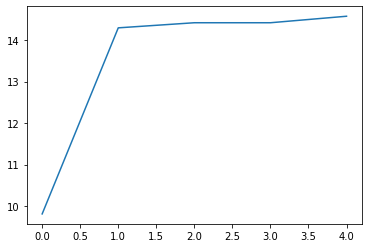

In [6]:
ga = GA(fit, model, inputs, db_flag)
ga.initPopulation(init_input_mut, init_weight_mut, n)
ga.prepareFitness()
F, fits = ga_main(ga, r1, r2, mut_rate, m, n, layer_idx, 50)
plot_fits(fits)
print(F)

### NaN for theano

In [32]:
# parameters
fit = ["nan", ["theano"]]
inputs = x_test_224[:5]
db_flag = 3

init_input_mut = 0
init_weight_mut = 0

r1 = 0.5
r2 = 0.5
mut_rate = 3
m = 5
n = 100
layer_idx = -2

r = redis.Redis(db=db_flag)
r.flushdb()

True

Running at iteration 1:
top 5 fitness scores:  [ 8.408013  9.386361  9.707703 12.684577  8.876608]
Taken time: 32.46601438522339

Running at iteration 2:
top 5 fitness scores:  [13.7124195 13.89464   14.069366  14.087666  13.955507 ]
Taken time: 72.71084666252136

Running at iteration 3:
top 5 fitness scores:  [13.966047 14.022146 14.069366 14.087666 14.107145]
Taken time: 70.07884955406189

Running at iteration 4:
top 5 fitness scores:  [14.056664 14.069366 14.087666 14.107145 14.200651]
Taken time: 70.5026171207428

Running at iteration 5:
top 5 fitness scores:  [14.107145  14.187783  14.200651  14.2196865 14.320291 ]
Taken time: 71.84364438056946

Total taken time: 317.61353373527527
[]


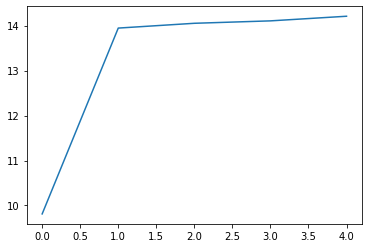

In [33]:
ga = GA(fit, model, inputs, db_flag)
ga.initPopulation(init_input_mut, init_weight_mut, n)
ga.prepareFitness()
F, fits = ga_main(ga, r1, r2, mut_rate, m, n, layer_idx, 50)
plot_fits(fits)
print(F)

### Inconsistency between tensorflow and theano

In [6]:
# parameters
fit = ["inc", ["tensorflow", "theano"]]
inputs = x_test_224[:5]
db_flag = 3

init_input_mut = 0
init_weight_mut = 0

r1 = 0.5
r2 = 0.5
mut_rate = 3
m = 5
n = 100
layer_idx = -2

r = redis.Redis(db=db_flag)
r.flushdb()

True

Running at iteration 1:
top 5 fitness scores:  [6.6043066e-07 7.4290483e-07 9.2021378e-07 8.1542879e-07 7.2645395e-07]
Taken time: 32.90242266654968

Running at iteration 2:
top 5 fitness scores:  [6.4453485e-07 7.3491503e-07 7.5075030e-07 9.0657545e-07 8.1347116e-07]
Taken time: 76.44327688217163

Running at iteration 3:
top 5 fitness scores:  [7.0089658e-07 7.3491503e-07 9.0657545e-07 7.5075030e-07 8.1347116e-07]
Taken time: 75.97916531562805

Running at iteration 4:
top 5 fitness scores:  [7.0089658e-07 7.3491503e-07 7.5075030e-07 8.1347116e-07 9.0657545e-07]
Taken time: 74.15697193145752

Running at iteration 5:
top 5 fitness scores:  [7.0089658e-07 8.1347116e-07 7.5075030e-07 7.3491503e-07 9.0657545e-07]
Taken time: 76.85342669487

Total taken time: 336.34239864349365
[]


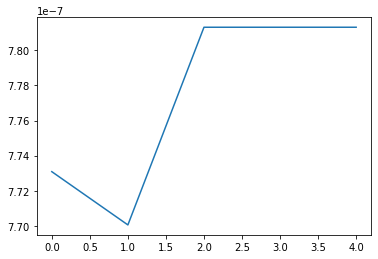

In [35]:
ga = GA(fit, model, inputs, db_flag)
ga.initPopulation(init_input_mut, init_weight_mut, n)
ga.prepareFitness()
F, fits = ga_main(ga, r1, r2, mut_rate, m, n, layer_idx, 50)
plot_fits(fits)
print(F)

# Testing 

## CIFAR-10 test data in VGG16 model

### Inconsistent prediction between tensorflow and theano

In [7]:
inc_idxs = get_diff_predictions_inputs(model, x_test_224, ['tensorflow', 'theano'], layer_idx, db_flag, 100)

100%|██████████| 100/100 [2:02:32<00:00, 73.53s/it] 


In [10]:
inc_idxs

array([], dtype=float64)

In [15]:
I, F = get_highest_fits(fit, model, x_test_224, layer_idx, db_flag, 100, 10)

100%|██████████| 9/9 [1:24:26<00:00, 562.92s/it]


In [41]:
# Highest fitness values throughout x_test_224
F[np.argpartition(F, -5)][-5:]

array([1.6132817e-06, 1.8387362e-06, 1.6832240e-06, 1.9658432e-06,
       1.6693361e-06], dtype=float32)

In [52]:
save_ckpt(I[np.argpartition(F, -5)[-5:]], 'inc', 'vgg16', 'tf_th', db_flag=5)

## CIFAR-10 test data in AlexNet model
### Inconsistent prediction between tensorflow and theano

In [105]:
inc_idxs = get_diff_predictions_inputs(model, x_test, ['tensorflow', 'theano'], layer_idx, db_flag, 20)

100%|██████████| 20/20 [08:13<00:00, 24.65s/it]


In [201]:
print('Out of {} inputs, {} are inconsistent'.format(len(x_test), len(inc_idxs)))

Out of 10000 inputs, 3216 are inconsistent


In [182]:
fit_ranks = rank_fits(fit, model, x_test, layer_idx, db_flag, 10)

100%|██████████| 9/9 [04:22<00:00, 29.15s/it]


100%|██████████| 10000/10000 [04:16<00:00, 38.98it/s]


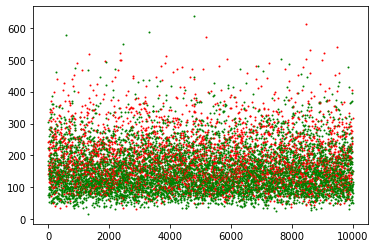

In [188]:
# show relationship between different prediction results and fitness values
for idx, fit in tqdm(fit_ranks):
    if idx in inc_idxs:
        c = "red"
    else:
        c = "green"
    plt.scatter(idx, fit, c=c, s=1)

### Examples for high fitness values but same prediction result

In [189]:
for idx, fit in tqdm(fit_ranks[:10]):
    if idx not in inc_idxs:
        print(idx)

100%|██████████| 10/10 [00:00<00:00, 10323.17it/s]

4792
3320
594
2465


In [195]:
ga = GA(['inc', ['tensorflow', 'theano']], model, x_test[4792], db_flag)
ga.mutated_inputs = x_test[4792]
ga.prepareFitness()
ga.computeFitness(layer_idx)

array(636.15564, dtype=float32)

In [199]:
ga.FFunc.predictions_1

array([[ 1389.632   ,  -715.98895 ,     9.746345,  -844.39514 ,
         1366.5066  , -1292.3542  ,   106.58764 ,   847.466   ,
         -377.76157 ,  -618.54706 ]], dtype=float32)

In [197]:
ga.FFunc.predictions_2

array([[ 1155.123   ,   -41.603157,    86.53187 ,  -295.92426 ,
         -100.25265 , -1434.2881  ,   858.269   ,  -567.51495 ,
           44.716965,    11.024116]], dtype=float32)

In [381]:
class SourceLocaliser:
    def __init__(self, model, frameworks, x, model_config, db_flag):
        self.redis_server = redis.Redis(db=db_flag)
        self.model = model
        self.backend_1, self.backend_2 = frameworks
        self.x = x
        self.model_config = model_config
        self.db_flag = db_flag
        
    def prepare(self):
        with self.redis_server.pipeline() as pipe:
            pipe.mset({"model": pickle.dumps(self.model)})
            pipe.mset({"inputs": pickle.dumps(self.x)})
            pipe.execute()
            
    def update_model(self, model):
        self.redis_server.mset({"model": pickle.dumps(model)})
        
    def update_x(self, x):
        self.redis_server.mset({"inputs": pickle.dumps(x)})
            
    # compute inconsistency fitness score
    def compute_all_layers_dist(self):
        cmd_1 = get_prediction_cmd(self.backend_1, self.db_flag, 'all')
        cmd_2 = get_prediction_cmd(self.backend_2, self.db_flag, 'all')

        p1 = Process(target=lambda: os.system(cmd_1))
        p2 = Process(target=lambda: os.system(cmd_2))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        
        # load predictions
        with self.redis_server.pipeline() as pipe:
            pipe.hget("predictions", self.backend_1)
            pipe.hget("predictions", self.backend_2)
            predictions = pipe.execute()

        predictions_1 = pickle.loads(predictions[0])
        predictions_2 = pickle.loads(predictions[1])
        
        assert len(predictions_1) == len(predictions_2)
        
        self.layers_dist = []
        for i in range(len(predictions_1)):
            predictions_diff = np.abs(predictions_1[i] - predictions_2[i]).ravel()
            self.layers_dist.append(np.sum(predictions_diff) / len(predictions_diff))
        
        return self.layers_dist
    
    # compute rate of change of inconsistency fitness score betwen layers
    def compute_dists_change(self, layer_idx, epsilon=10**-7):
        max_prev_layers_dist = max(self.layers_dist[:layer_idx])
        self.dists_change = (self.layers_dist[layer_idx] - max_prev_layers_dist) / (max_prev_layers_dist + epsilon)
        return self.dists_change
    
    
    # return only layer indexes with rate of change larger than t1
    def t1_dists_change(self, t1):
        self.compute_all_layers_dist() # prepare for the subsequent computations
        self.t1_layers = []
        for i in range(2, len(model.layers)): # choose 2 to escape the distance jump from the input layer
            layer_change = self.compute_dists_change(i)
            if layer_change >= t1:
                self.t1_layers.append([model.layers[i], i])
        return self.t1_layers
    
    # create a new layer based on config
    def replace(self, L, new_config):
        L_prime = L.from_config(new_config)
        return L_prime
    
    # create a simple model using 1 layer L_prime 
    def create_test_model(self, L_prime):
        test_model = keras.Sequential()
        test_model.add(L_prime)
        # not sure if need to call model.build()
        return test_model
    
    # check errors while running the newly created model
    def checkCrash_NaN(self, f_prime):
        self.update_model(f_prime)
        cmd_1 = get_prediction_cmd(self.backend_1, self.db_flag, 'error')
        cmd_2 = get_prediction_cmd(self.backend_2, self.db_flag, 'error')

        p1 = Process(target=lambda: os.system(cmd_1))
        p2 = Process(target=lambda: os.system(cmd_2))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        
        # load errors
        with self.redis_server.pipeline() as pipe:
            pipe.hget("errors", self.backend_1)
            pipe.hget("errors", self.backend_2)
            errors = pipe.execute()
            
        errors_1 = pickle.loads(errors[0])
        errors_2 = pickle.loads(errors[1])
        
        errors = []
        if errors_1 != []:
            errors.append([errors_1, self.backend_1])
            
        if errors_2 != []:
            errors.append([errors_1, self.backend_2])
            
        return errors
    
    def fixDNN(self, f, X, L_prime, L_idx):
        pass
    
    def main(self, t1, t2):
        X = []
        Y = []
        
        for _ in tqdm(range(5)):
            beta = self.t1_dists_change(t1)
            if beta == []: # finish localization
                return X, Y
            
            L, L_idx = beta[0]
            
            if L_idx in self.model_config:
                a_L = self.model_config[L_idx]
            else:
                continue
            
            P = []
            for a in a_L:
                L_prime = self.replace(L, a)
                f_prime = self.create_test_model(L_prime)
                
                # update inputs to fit the newly created model f_prime
                x_prime = self.redis_server.hget("predictions", self.backend_1)[L_idx-1]
                self.update_x(x_prime)
                
                y = self.checkCrash_NaN(f_prime)
                if y != []:
                    Y.append([y, L_idx, a])
                else:
                    continue
                    x_max = detectInconsistency(f_prime) # when to stop?
                    self.update_x(x_max)
                    
                    if self.compute_dists_change(L_idx) < t2:
                        P.append(a)
                    
                    if P != []:
                        X.append([L, P]) # why keep appending P
                        
                    f = self.fixDNN(f, X, L_prime, L_idx)
                
        return X, Y

In [368]:
model_configs = {}
model_configs[2] = [model.layers[2].get_config()]
model_configs[2][0]['padding'] = 'same'

In [369]:
model_configs

{2: [{'name': 'max_pooling2d_1',
   'trainable': True,
   'dtype': 'float32',
   'pool_size': (2, 2),
   'padding': 'same',
   'strides': (2, 2),
   'data_format': 'channels_last'}]}

In [394]:
SL = SourceLocaliser(model, ['tensorflow', 'theano'], inc_ckpt[0], model_configs, 1)
SL.prepare()

In [395]:
SL.compute_all_layers_dist()
for i in range(1, len(model.layers)):
    print(SL.compute_dists_change(i))

118.79106156756076
1.9433135824855179
0.04510970254377995
1.6234224919364755
0.3343521944877438
0.16150764492263509
0.09848952029466206
0.22027278025340166
-0.5106200738533972
-0.3141403937510773
-0.5684290689196673
-0.741985188276687
-0.9328100438428549
-0.8862933671836476
-0.9445422654019134
-0.9708708819090881
-0.9940020413255433
-0.9895945880930225
-0.9895945880930225
-0.9911734050422664
-0.9972718498771508
-0.9911372687183836
-0.999486176257197


In [390]:
inc_ckpt = load_ckpt('inc', 'vgg16', 'tf_th', db_flag=5)